GroupId„ÇíÊåáÂÆö„Åó„Å¶„ÄÅ„Åù„ÅÆ‰∏≠„ÅÆSensorid„Åô„Åπ„Å¶„ÇíË™ø„Åπ„Çã


In [ ]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


# .env Ë™≠„ÅøËæº„Åø
print(r"..\environment\.env")
load_dotenv(dotenv_path=r'..\environment/.env',override=True)

# =========================
# üîê Metabase Ë™çË®º„Éª„Éá„Éº„ÇøÂèñÂæó
# =========================

login_url = "https://metabase.tr-com.net/api/session"
username = os.getenv("MB_USERNAME", "").strip()
password = os.getenv("MB_PASSWORD", "").strip()

if not username or not password:
    raise ValueError("‚ùå MB_USERNAME „Åæ„Åü„ÅØ MB_PASSWORD „ÅåË®≠ÂÆö„Åï„Çå„Å¶„ÅÑ„Åæ„Åõ„Çì")

print(f"„É≠„Ç∞„Ç§„É≥Ë©¶Ë°å‰∏≠ ‚Üí username: '{username}'")

response = requests.post(login_url, json={"username": username, "password": password})
if response.status_code == 200:
    session_id = response.json().get("id")
    print("‚úÖ „É≠„Ç∞„Ç§„É≥ÊàêÂäü")
else:
    raise Exception(f"‚ùå „É≠„Ç∞„Ç§„É≥Â§±Êïó: {response.status_code}, {response.text}")


..\environment\.env
„É≠„Ç∞„Ç§„É≥Ë©¶Ë°å‰∏≠ ‚Üí username: 'y-nitta@torishima.co.jp'
‚úÖ „É≠„Ç∞„Ç§„É≥ÊàêÂäü


groupIdÊåáÂÆö

In [ ]:

# „Éá„Éº„ÇøÂèñÂæó
url = "https://metabase.tr-com.net/api/card/2097/query/json"
headers = {
    "Content-Type": "application/json",
    "X-Metabase-Session": session_id
}

# Payload
payload = {
    "parameters": [
        {
            "type": "category",
            "target": ["variable", ["template-tag", "GroupId"]],
            "value": "394"
        }
    ]
}

response = requests.post(url, headers=headers, json=payload)
if response.status_code == 200:
    try:
        data = response.json()
        dfori = pd.DataFrame(data)
        if dfori.empty:
            raise ValueError("‚ùå ÂèñÂæó„Åó„Åü„Éá„Éº„Çø„ÅåÁ©∫„Åß„Åô„ÄÇMetabase„ÇíÁ¢∫Ë™ç„Åó„Å¶„Åè„Å†„Åï„ÅÑ„ÄÇ")
        print("‚úÖ „Éá„Éº„ÇøÂèñÂæóÊàêÂäü")
        print(dfori.head())

    except Exception as e:
        raise Exception(f"‚ùå „Éá„Éº„ÇøÂèñÂæó„ÉªDataFrameÂ§âÊèõÂ§±Êïó: {e}")
else:
    raise Exception(f"‚ùå „Éá„Éº„ÇøÂèñÂæóÂ§±Êïó: {response.status_code}, {response.text}")


‚úÖ „Éá„Éº„ÇøÂèñÂæóÊàêÂäü
   GroupId   GroupName  SensorId  ParentGroupId GroupType
0      394  ‰∏∏„ÅÆÂÜÖÁÜ±‰æõÁµ¶Ê†™Âºè‰ºöÁ§æ  VB0F4E10           1290         C
1      394  ‰∏∏„ÅÆÂÜÖÁÜ±‰æõÁµ¶Ê†™Âºè‰ºöÁ§æ  VB0FFF8A           1290         C
2      394  ‰∏∏„ÅÆÂÜÖÁÜ±‰æõÁµ¶Ê†™Âºè‰ºöÁ§æ  VB35B2D8           1290         C
3      394  ‰∏∏„ÅÆÂÜÖÁÜ±‰æõÁµ¶Ê†™Âºè‰ºöÁ§æ  VB35E4EE           1290         C
4      394  ‰∏∏„ÅÆÂÜÖÁÜ±‰æõÁµ¶Ê†™Âºè‰ºöÁ§æ  VB35EC56           1290         C


In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def analyze_sensor_data(sensor_id, session_id):
    """
    ÊåáÂÆö„Åï„Çå„Åü sensor_id „ÅÆÊôÇÁ≥ªÂàó„Éá„Éº„Çø„ÇíÂèñÂæó„Åó„ÄÅ„ÇØ„É©„Çπ„Çø„É™„É≥„Ç∞ÂàÜÊûê„ÇíË°å„ÅÜ„ÄÇ
    „Çª„É≥„Éà„É≠„Ç§„Éâ„Åã„Çâ„ÅÆË∑ùÈõ¢„Çí0„Äú1„Å´Ê≠£Ë¶èÂåñ„Åó„ÄÅrecord_dateÂàó„ÇíÂê´„ÇÅ„Å¶Ëøî„Åô„ÄÇ

    Parameters:
        sensor_id (str): ÂØæË±°„Çª„É≥„Çµ„ÉºID
        session_id (str): Metabase„ÅÆ„Çª„ÉÉ„Ç∑„Éß„É≥ID

    Returns:
        pd.DataFrame: „ÇØ„É©„Çπ„Çø„É™„É≥„Ç∞„Å®Ë∑ùÈõ¢„ÄÅÊ≠£Ë¶èÂåñË∑ùÈõ¢„ÇíÂê´„ÇÄ DataFrameÔºàrecord_dateÂàó„ÅÇ„ÇäÔºâ
    """

    # Metabase API„Åß„Éá„Éº„ÇøÂèñÂæó
    url = "https://metabase.tr-com.net/api/card/2092/query/json"
    headers = {
        "Content-Type": "application/json",
        "X-Metabase-Session": session_id
    }
    payload = {
        "parameters": [
            {
                "type": "category",
                "target": ["variable", ["template-tag", "sensorid"]],
                "value": sensor_id
            }
        ]
    }

    response = requests.post(url, headers=headers, json=payload)

    if response.status_code != 200:
        raise Exception(f"‚ùå „Éá„Éº„ÇøÂèñÂæóÂ§±Êïó: {response.status_code}, {response.text}")

    data = response.json()
    dfori = pd.DataFrame(data)

    if dfori.empty:
        raise ValueError("‚ùå ÂèñÂæó„Åó„Åü„Éá„Éº„Çø„ÅåÁ©∫„Åß„Åô„ÄÇMetabase„ÇíÁ¢∫Ë™ç„Åó„Å¶„Åè„Å†„Åï„ÅÑ„ÄÇ")

    # „Éá„Éº„ÇøÊï¥ÂΩ¢
    df = dfori.copy()
    df['record_date'] = pd.to_datetime(df['record_date'])
    df = df[['record_date', 'GroupId', 'SensorId', 'x_vrmsacc']].dropna()
    df = df.set_index('record_date')

    # „ÇØ„É©„Çπ„Çø„É™„É≥„Ç∞
    X = df[['x_vrmsacc']].values
    kmeans = KMeans(n_clusters=2, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    # „Çª„É≥„Éà„É≠„Ç§„Éâ„Åã„Çâ„ÅÆË∑ùÈõ¢
    centroids = kmeans.cluster_centers_
    assigned_centroids = centroids[df['cluster']]
    df['distance_to_center'] = np.linalg.norm(X - assigned_centroids, axis=1)

    # Min-MaxÊ≠£Ë¶èÂåñ
    scaler = MinMaxScaler()
    df['distance_to_center_normalized'] = scaler.fit_transform(df[['distance_to_center']])

    # record_date „ÇíÂàó„Å´Êàª„Åô
    df['record_date'] = df.index

    # ÁµêÊûú„Å®„Åó„Å¶Ëøî„ÅôÂàó
    df_final = df[['record_date', 'GroupId', 'SensorId', 'cluster', 'distance_to_center', 'distance_to_center_normalized']]

    return df_final


In [ ]:
sensor_id = dfori["SensorId"].iloc[0]

df_result = analyze_sensor_data(sensor_id, session_id)
print(df_result.head())


                            record_date  GroupId  SensorId  cluster  \
record_date                                                           
2020-07-03 16:17:23 2020-07-03 16:17:23      394  VB0F4E10        1   
2020-07-03 15:17:23 2020-07-03 15:17:23      394  VB0F4E10        1   
2020-07-03 14:17:23 2020-07-03 14:17:23      394  VB0F4E10        1   
2020-07-03 13:17:23 2020-07-03 13:17:23      394  VB0F4E10        1   
2020-07-03 12:17:23 2020-07-03 12:17:23      394  VB0F4E10        1   

                     distance_to_center  distance_to_center_normalized  
record_date                                                             
2020-07-03 16:17:23            0.661267                       0.005118  
2020-07-03 15:17:23            0.661267                       0.005118  
2020-07-03 14:17:23            0.661267                       0.005118  
2020-07-03 13:17:23            0.267566                       0.001527  
2020-07-03 12:17:23            0.661267                       0.

In [ ]:
results = []


for i in range(len(dfori)):

    sensor_id = dfori["SensorId"].iloc[i]
    print(f"üîé Âá¶ÁêÜ‰∏≠ SensorId: {sensor_id}")
    
    try:
        df_result = analyze_sensor_data(sensor_id, session_id)
        results.append(df_result)
    
    except Exception as e:
        print(f"‚ùå SensorId {sensor_id} „ÅÆÂá¶ÁêÜ‰∏≠„Å´„Ç®„É©„Éº: {e}")

# „Åô„Åπ„Å¶„ÅÆÁµêÊûú„ÇíÁµêÂêà
if results:
    df_all_results = pd.concat(results, ignore_index=True)

    # record_date„ÅßÊòáÈ†Ü„ÇΩ„Éº„Éà
    df_all_results = df_all_results.sort_values(by="record_date").reset_index(drop=True)

    print("‚úÖ ÂÖ®„Çª„É≥„Çµ„ÉºÂàÜ„ÅÆÈõÜË®àÁµêÊûúÔºàrecord_dateÈ†ÜÔºâ:")
    print(df_all_results.head())

else:
    print("‚ùó ÁµêÊûú„ÅåÁ©∫„Åß„Åô„ÄÇ")



üîé Âá¶ÁêÜ‰∏≠ SensorId: VB0F4E10
üîé Âá¶ÁêÜ‰∏≠ SensorId: VB0FFF8A
üîé Âá¶ÁêÜ‰∏≠ SensorId: VB35B2D8
üîé Âá¶ÁêÜ‰∏≠ SensorId: VB35E4EE
‚úÖ ÂÖ®„Çª„É≥„Çµ„ÉºÂàÜ„ÅÆÈõÜË®àÁµêÊûúÔºàrecord_dateÈ†ÜÔºâ:
          record_date  GroupId  SensorId  cluster  distance_to_center  \
0 2019-09-03 04:36:50      394  VB0F4E10        1            2.629771   
1 2019-09-03 04:48:13      394  VB0FFF8A        1           20.310030   
2 2019-09-03 04:52:17      394  VB35E4EE        0            8.938006   
3 2019-09-03 05:04:35      394  VB35B2D8        1            9.419806   
4 2019-09-03 05:36:50      394  VB0F4E10        1            1.448669   

   distance_to_center_normalized  
0                       0.023071  
1                       0.235190  
2                       0.099457  
3                       0.072780  
4                       0.012299  


In [ ]:
print(df_all_results[["record_date", "cluster", "distance_to_center_normalized"]].head(20))


           record_date  cluster  distance_to_center_normalized
0  2019-09-03 04:36:50        1                       0.023071
1  2019-09-03 04:48:13        1                       0.235190
2  2019-09-03 04:52:17        0                       0.099457
3  2019-09-03 05:04:35        1                       0.072780
4  2019-09-03 05:36:50        1                       0.012299
5  2019-09-03 05:48:12        1                       0.027965
6  2019-09-03 05:52:17        0                       0.004439
7  2019-09-03 06:04:34        1                       0.042717
8  2019-09-03 06:36:50        1                       0.012299
9  2019-09-03 06:48:12        1                       0.027965
10 2019-09-03 06:52:17        0                       0.000000
11 2019-09-03 07:04:34        1                       0.045768
12 2019-09-03 07:36:50        1                       0.012299
13 2019-09-03 07:48:12        1                       0.023378
14 2019-09-03 07:52:17        0                       0

In [ ]:
import pandas as pd

# record_date„ÇídatetimeÂûã„Å´Â§âÊèõ
df_all_results['record_date'] = pd.to_datetime(df_all_results['record_date'])

# record_date„Çí1ÊôÇÈñìÂçò‰Ωç„Å´‰∏∏„ÇÅ„Çã
df_all_results['hour'] = df_all_results['record_date'].dt.floor('H')

# 1ÊôÇÈñì„Åî„Å® & „ÇØ„É©„Çπ„Çø„Åî„Å®„Å´„Ç∞„É´„Éº„ÉóÂåñ„Åó„Å¶Âπ≥Âùá„ÇíË®àÁÆó
mean_distances = df_all_results.groupby(['hour', 'cluster'])['distance_to_center_normalized'].mean().reset_index()

# ÁµêÊûú„ÅÆË°®Á§∫ÔºàÂøÖË¶Å„Åß„ÅÇ„Çå„Å∞„ÇΩ„Éº„ÉàÔºâ
print(mean_distances.sort_values(by=['hour', 'cluster']))


                     hour  cluster  distance_to_center_normalized
0     2019-09-03 04:00:00        0                       0.099457
1     2019-09-03 04:00:00        1                       0.129131
2     2019-09-03 05:00:00        0                       0.004439
3     2019-09-03 05:00:00        1                       0.037681
4     2019-09-03 06:00:00        0                       0.000000
...                   ...      ...                            ...
99981 2025-06-08 02:00:00        1                       0.070195
99982 2025-06-08 03:00:00        0                       0.332506
99983 2025-06-08 03:00:00        1                       0.125885
99984 2025-06-08 04:00:00        0                       0.433200
99985 2025-06-08 04:00:00        1                       0.115497

[99986 rows x 3 columns]


C:\Users\H6445\AppData\Local\Temp\ipykernel_14976\2006540064.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_all_results['hour'] = df_all_results['record_date'].dt.floor('H')


In [ ]:
import pandas as pd
import numpy as np

# 1. groupbyÁµêÊûú„ÇíDataFrame„Å´Â§âÊèõ
mean_distances_df = mean_distances.reset_index()

# 2. „Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´ÂåñÔºöË°å = hour„ÄÅÂàó = cluster
pivot_df = mean_distances_df.pivot(index='hour', columns='cluster', values='distance_to_center_normalized')

# 3. ÂêÑ„ÇØ„É©„Çπ„Çø„ÅÆË∑ùÈõ¢ÂèñÂæóÔºàÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØNaNÔºâ
distance_0 = pivot_df.get(0)
distance_1 = pivot_df.get(1)

# 4. ÂÑ™Âã¢„ÇØ„É©„Çπ„Çø„ÇíÂà§ÂÆöÔºàNaNËÄÉÊÖÆÔºâ
dominant_cluster = np.where(
    distance_0.isna(), 1,  # 0„ÅåNaN ‚Üí 1„ÅåÂ≠òÂú® ‚Üí cluster 1 „ÅåÂÑ™Âã¢
    np.where(
        distance_1.isna(), 0,  # 1„ÅåNaN ‚Üí 0„ÅåÂ≠òÂú® ‚Üí cluster 0 „ÅåÂÑ™Âã¢
        np.where(distance_0 < distance_1, 0, 1)  # ‰∏°Êñπ„ÅÇ„Çã ‚Üí Â∞è„Åï„ÅÑÊñπ„ÅåÂÑ™Âã¢
    )
)

# 5. ÂÑ™Âã¢Â∫¶ÔºàË∑ùÈõ¢Â∑ÆÔºöNaNÂê´„ÇÄÂ†¥Âêà„ÅØ„Åù„ÅÆ„Åæ„Åæ„Å´„Åô„ÇãÔºâ
distance_diff = (distance_0 - distance_1).abs()

# 6. ÁµêÊûú„ÇíDataFrame„Å´„Åæ„Å®„ÇÅ„Çã
dominance_df = pd.DataFrame({
    'hour': pivot_df.index,
    'dominant_cluster': dominant_cluster,
    'distance_diff': distance_diff
})

# 7. Ë°®Á§∫ÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶„ÇΩ„Éº„Éà„ÇÇÂèØÔºâ
print(dominance_df)


                                   hour  dominant_cluster  distance_diff
hour                                                                    
2019-09-03 04:00:00 2019-09-03 04:00:00                 0       0.029674
2019-09-03 05:00:00 2019-09-03 05:00:00                 0       0.033242
2019-09-03 06:00:00 2019-09-03 06:00:00                 0       0.027660
2019-09-03 07:00:00 2019-09-03 07:00:00                 0       0.022709
2019-09-03 08:00:00 2019-09-03 08:00:00                 0       0.024239
...                                 ...               ...            ...
2025-06-08 00:00:00 2025-06-08 00:00:00                 1       0.290148
2025-06-08 01:00:00 2025-06-08 01:00:00                 1       0.302744
2025-06-08 02:00:00 2025-06-08 02:00:00                 1       0.271712
2025-06-08 03:00:00 2025-06-08 03:00:00                 1       0.206621
2025-06-08 04:00:00 2025-06-08 04:00:00                 1       0.317703

[50385 rows x 3 columns]


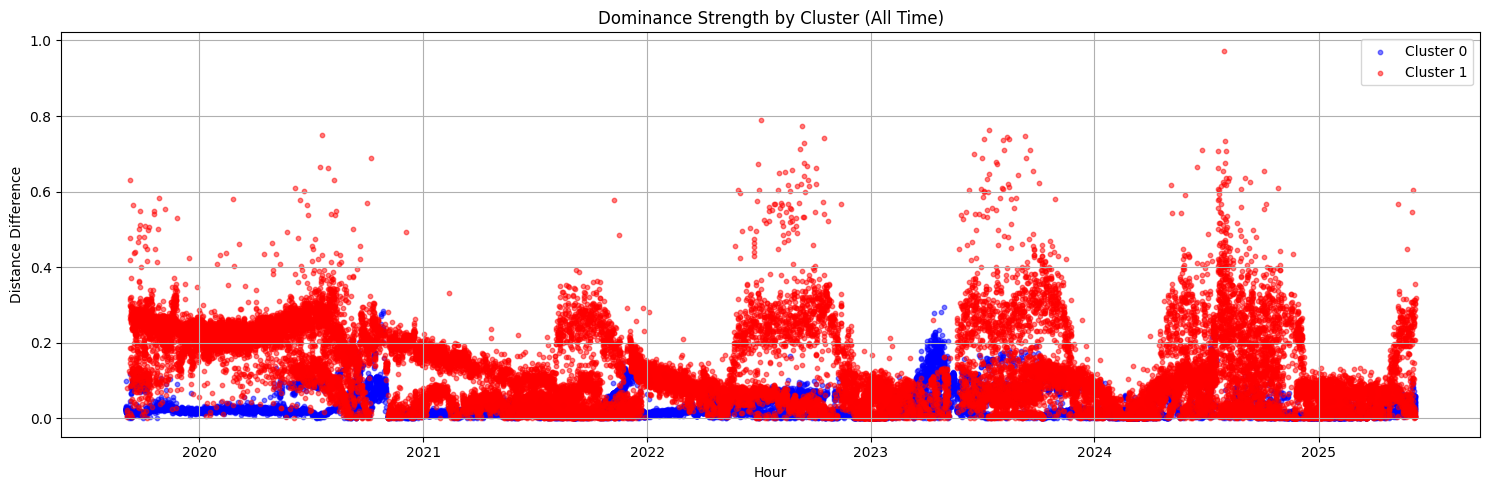

In [ ]:
import matplotlib.pyplot as plt

# 'hour' „Çí datetime „Å´ÔºàÂøµ„ÅÆ„Åü„ÇÅÔºâ
dominance_df['hour'] = pd.to_datetime(dominance_df['hour'])

# „ÇØ„É©„Çπ„Çø„Åî„Å®„Å´„Éï„Ç£„É´„ÇøÔºàÂÖ®ÊúüÈñìÔºâ
cluster_0_df = dominance_df[dominance_df['dominant_cluster'] == 0]
cluster_1_df = dominance_df[dominance_df['dominant_cluster'] == 1]

# „Éó„É≠„ÉÉ„ÉàÈñãÂßã
plt.figure(figsize=(15, 5))

# „ÇØ„É©„Çπ„Çø0„ÅÆ„Éó„É≠„ÉÉ„ÉàÔºàÈùíÔºâ
plt.scatter(cluster_0_df['hour'], cluster_0_df['distance_diff'], color='blue', s=10, alpha=0.5, label='Cluster 0')

# „ÇØ„É©„Çπ„Çø1„ÅÆ„Éó„É≠„ÉÉ„ÉàÔºàËµ§Ôºâ
plt.scatter(cluster_1_df['hour'], cluster_1_df['distance_diff'], color='red', s=10, alpha=0.5, label='Cluster 1')

# Ëª∏„ÉªÂá°‰æã„Å™„Å©
plt.xlabel('Hour')
plt.ylabel('Distance Difference')
plt.title('Dominance Strength by Cluster (All Time)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


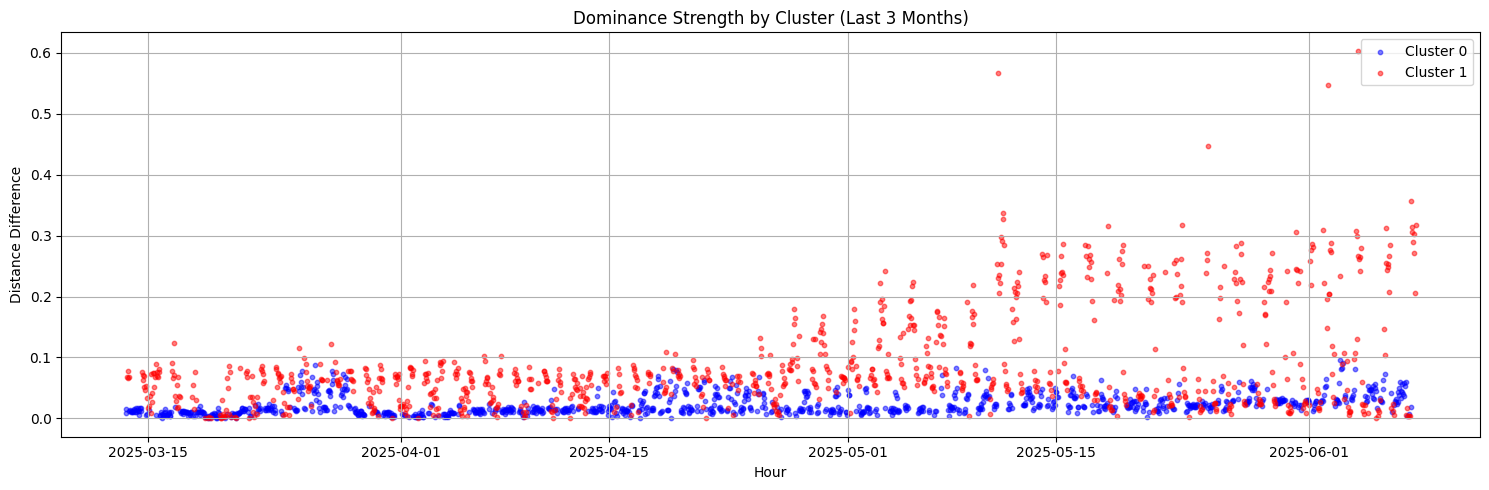

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# 'hour' „Çí datetime „Å´Â§âÊèõÔºàÂøµ„ÅÆ„Åü„ÇÅÔºâ
dominance_df['hour'] = pd.to_datetime(dominance_df['hour'])

# ‰ªäÊó•„ÅÆÊó•‰ªò„ÇíÂèñÂæó„Åó„ÄÅ3„ÅãÊúàÂâç„ÅÆÊó•‰ªò„ÇíË®àÁÆó
end_date = datetime.today()
start_date = end_date - timedelta(days=90)

# Áõ¥Ëøë3„ÅãÊúà„ÅÆ„Éá„Éº„Çø„Å´„Éï„Ç£„É´„Çø„Éº
recent_df = dominance_df[(dominance_df['hour'] >= start_date) & (dominance_df['hour'] <= end_date)]

# „ÇØ„É©„Çπ„Çø„Åî„Å®„Å´„Éï„Ç£„É´„Çø„Éº
cluster_0_df = recent_df[recent_df['dominant_cluster'] == 0]
cluster_1_df = recent_df[recent_df['dominant_cluster'] == 1]

# „Éó„É≠„ÉÉ„ÉàÈñãÂßã
plt.figure(figsize=(15, 5))

# „ÇØ„É©„Çπ„Çø0„ÅÆ„Éó„É≠„ÉÉ„ÉàÔºàÈùíÔºâ
plt.scatter(cluster_0_df['hour'], cluster_0_df['distance_diff'], color='blue', s=10, alpha=0.5, label='Cluster 0')

# „ÇØ„É©„Çπ„Çø1„ÅÆ„Éó„É≠„ÉÉ„ÉàÔºàËµ§Ôºâ
plt.scatter(cluster_1_df['hour'], cluster_1_df['distance_diff'], color='red', s=10, alpha=0.5, label='Cluster 1')

# Ëª∏„ÉªÂá°‰æã„Å™„Å©
plt.xlabel('Hour')
plt.ylabel('Distance Difference')
plt.title('Dominance Strength by Cluster (Last 3 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
